# IMPORTS AND FUNCTION DEFINITIONS

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
from numpy.linalg import norm
from itertools import combinations

from plotter import *
from plotnine import *
from easyesn.optimizers import GradientOptimizer
from easyesn import PredictionESN
from easyesn import BaseESN
# note: you must make this change in the easyesn code
# https://github.com/kalekiu/easyesn/issues/12
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp
import ipywidgets as widgets
from IPython.display import display, Markdown, Latex

%matplotlib inline


""" NOTES:
    This file provides mechanisms to:
    A) Data Processing
        1) Load trajectories from csv files ( file must contain columns 'x', 'y')
        2) Create a trajectory from a trajectory generator (see more documentation in respective function)
        3) Load a generator from a csv file
        4) Load a set of feeders from a csv file
        5) Generate a matrix of place cell activations (row=place cell, column=time_index) 
           pc activation computed according to following formula:
                 e^( log(K) * ||pos - pc_center||^2 / r^2  )
           where 
                r is the place cell's radius
                K is the place cell's activation value at the radius
    
    B) Plot data
        Imports functionalities from 'plotter.py' which uses library matplotlib
"""


# CONSTANTS
PC_VALUE_AT_RADIUS = 0.8  # 0.2 activation value (constant K in pc activation formula)


def list_files(folder, extension=""):
    """ lost all files in the folder with the given extension
    """
    return sorted([ f for f in os.listdir(folder) if f.endswith(extension)])

def pad_single_sequence(s, length):
    """ Pads a dataframe so that it has the given length.
        we expect len(s) < length, if so, the first element is repeated as necessary.
    """
    pad_vectors = [ s.loc[[0]] ] * (length - len(s))
    return pd.concat([* pad_vectors , s]).reset_index(drop=True)

def pad_all_sequences(sequences):
    """
        Pads all sequences so that they have the same number of elements.
        Padding is added by repeating the first element as necessary
    """
    longest = max([ len(s) for s in sequences.values() ])
    return { k : pad_single_sequence(s, longest) for k, s in sequences.items() }

def calculate_sequence_mean_displacement(sequence):
    """
        Calculates the mean distance between consecutive points in the sequence.
    """
    num_data = len(sequence)
    displacements = sequence.loc[0:(num_data-2)].reset_index(drop=True) - sequence.loc[1:(num_data-1)].reset_index(drop=True)    
    return norm(displacements, axis=1).mean()

def load_path(file_name):
    """" load csv fle specifying a path
         file must contain at least columns 'x' and 'y'
    """
    return pd.read_csv(file_name, delim_whitespace=True)
    # return sequence[['x', 'y']].to_numpy()


def load_generator(file_name):
    """" load csv fle specifying a path generator
             file must contain at least columns 'x', 'y' and 'steps'
        """
    return pd.read_csv(file_name, delim_whitespace=True)


def generate_path(generator):
    """ Generate a path using a generator
        'generator' is a pandas data frame containing at least 3 columns 'x' 'y' and 'steps'
        Column 'steps' indicate the number of step to reach the following way point (the
        value in the last row is ignored since it is the last point in the path)
    """

    # convert data to numpy arrays
    xy = generator[['x', 'y']].to_numpy()  # waypoints
    steps = generator['steps'].to_numpy()  #

    # interpolate each segment
    # endpoint=False will avoid repeating the last coordinate of each segment
    interpolator = lambda m_tuple: np.linspace(*m_tuple, endpoint=False)
    data = zip(xy[:-1], xy[1:], steps[:-1])
    path = np.concatenate(list(map(interpolator, data)) + [[xy[-1]]])
    return pd.DataFrame(path, columns=['x', 'y'])


def load_feeders(file_name):
    """"Function to load a set of feeders"""
    return pd.read_csv(file_name, delim_whitespace=True)[['x', 'y']]


def load_place_cells(file_name):
    """" Load csv fle specifying a set of place cells
         file must contain at least columns 'x', 'y' and 'placeradius'
    """
    return pd.read_csv(file_name, delim_whitespace=True)
    # return pcs[['x', 'y']].to_numpy(), pcs['placeradius'].to_numpy()


def calc_activation_matrix(path, pcs):
    """ Calculate a matrix containing the activation of all place cells for all times.
        Each row represents a place cell, while columns represent the time index.
        Both 'pos' and 'pcs' are data frames containing the path and the set of place cells.
    """
    # get number of pcs and position in path
    num_pcs = len(pcs)
    num_pos = len(path)

    # convert data to numpy to operate
    radii = pcs['placeradius'].to_numpy()
    pcs = pcs[['x', 'y']].to_numpy()
    pos = path[['x', 'y']].to_numpy()

    # replicate the position vector by the number of place cells for easy operations
    pos_tile = pos.reshape(1, -1, 2)
    pos_all = np.tile(pos_tile, (num_pcs, 1, 1))

    # replicate the place cells and radii by the number of positions for easy operations
    pcs_tile = pcs.reshape(-1, 1, 2)
    pcs_all = np.tile(pcs_tile, (1, num_pos, 1))
    radii_all = np.tile(radii.reshape((-1, 1)), (1, num_pos))

    # calculate the activations (see description of formula at the top of this file)
    delta = pos_all - pcs_all
    delta2 = (delta * delta).sum(2)
    r2 = radii_all * radii_all
    exponents = np.log(PC_VALUE_AT_RADIUS) * delta2 / r2
    activations = np.exp(exponents)
    return activations


def plot_paths_and_activations(pcs, sequence, activations, save_name, compare_sequence = None, title='', output_folder=''):
    """
        Creates figures with two subplots.
        Left plot shows heatmap representing the activation of the sequence vs time.
        Right plot shows the place cells in space, and the sequence path.
        If a compare sequence is given, the right plot also includes a second sequence to compare to
    """
    # create ouput folder if it doesnt exist:
    make_dirs(output_folder)
    
    fig, axs = plt.subplots(1, 2 )
    fig.suptitle(title)
    f1 = axs[0]
    f2 = axs[1]
    f2.autoscale(enable=True)
    f2.set_aspect('equal')
    plot_activation_matrix_heatmap(activations, plot=f1)

    plot_place_cells(pcs, plot=f2)  # add place cells to figure
#    plot_maze(plot=f2)
    if compare_sequence is not None:
        plot_path(compare_sequence, plot=f2)
    plot_path(sequence, plot=f2)
#    plot_feeders(feeders, plot=f2, s=80, zorder=2)  # zorder can be used to move the layer up or down
    plt.savefig(output_folder + save_name, dpi = 1200)
    
    return fig


def cos_sim(v1, v2):
    """
        Returns the cosine similitude between two vectors
    """
    return np.dot(v1, v2) / (norm(v1) * norm(v2))


def create_and_train_reservoir(activations):
    """
        Creates and trains the reservoir network.
        Activation sequences is used as input and expected output of the network.
        Rows are expected to be place cells, while columns are expected to represent time indeces
    """
    
    # initialize random seed, and set reservoir dimensions
    np.random.seed(1)
    vectorDim = len(activations) # reservoir input dimension
    numNode = 400   # number of reservoir nodes

    # create training input and output sets, augment it 2^10 times: 
    inputDataTraining = activations.T 
    outputDataTraining = activations.T
    print('activation shape:', activations.shape) 
    print('input data shape:', inputDataTraining.shape)

    # augment data by concatenating 2^10 times
    inputDataTraining = np.concatenate( [ inputDataTraining ] * 1024, axis = 0 )
    outputDataTraining=inputDataTraining
    print('augmented data shape:', inputDataTraining.shape)

    # create and train network: 
    esn = PredictionESN(n_input=vectorDim, n_output=vectorDim, n_reservoir=numNode, leakingRate=0.05, regressionParameters=[1e-2], solver="lsqr", feedback=False)
    esn.fit(inputDataTraining, outputDataTraining, transientTime="Auto", verbose=1)
    return esn

def predict_reservoir(trained_reservoir, activations, continuation=False):
    """
        Uses the trained reservoir to predict using the activations as input
        Activations should be a matrix with rows indicating pcs and columns indicating time
        Resturns only the last few states
    """
    prediction, reservoirStatesBuffer = trained_reservoir.predict(activations.T, continuation=continuation)
    # print(reservoirStatesBuffer.shape)
    return prediction, reservoirStatesBuffer[257:,:].T

def plot_can_reservoir_distinguish_sequences( activations, states, integrators, input_similitudes, state_similitudes, integrator_similitudes, s1, s2, output_folder=''):
    """
        Generates a plot with 6 subplots
    """
    
    fig= plt.figure(figsize=(10,10))
    fig.suptitle(f'Sequences: {s1} VS {s2}')
    #fig.suptitle('State Trajectories', fontsize=16)
    #fig.suptitle('State Trajectories')

    plt.subplot(331)
    plt.title('Input Temporal Structure 1')
    #plt.plot( inputDataTesting[:76,:])
    #sns.heatmap(activations, cmap="seismic")
    sns.heatmap(activations[s1])
    #plt.ylim([-1.1,1])
    
    plt.subplot(334)
    plt.title('Input Temporal Structure 2')
    #plt.plot( inputDataTesting2[:76,:])
    #sns.heatmap(activations2, vmin=0.4, vmax=1)
    sns.heatmap(activations[s2])
    #plt.ylim([-1.1,1])
   


    plt.subplot(337)
    plt.title('Inputs Cosine Similarity')
    plt.plot( input_similitudes[s1][s2])
    plt.ylim([0,1.1])

    plt.subplot(338)
    plt.title('Reservoir States Cosine Similarity')
    plt.plot( state_similitudes[s1][s2])
    plt.ylim([0,1.1])
    
    plt.subplot(339)
    plt.title('Integrator States Cosine Similarity')
    plt.plot( integrator_similitudes[s1][s2])
    plt.ylim([0,1.1])


    # Following we plot the reservoir temporal structure, we can simplify printing only the first 10 states
    resn = 10
    plt.subplot(332)
    plt.title('Reservoir States Temporal Structure 1')
    plt.plot( states[s1][s1][:,:resn])
    #plt.plot( inputDataTestingA[:,:5])
    plt.ylim([-1.1,1])
    
    plt.subplot(335)
    plt.title('Reservoir States Temporal Structure 2')
    plt.plot( states[s1][s2][:,:resn])
    #plt.plot( inputDataTestingB[:,:5])
    plt.ylim([-1.1,1])
    
    
    resn = 256
    plt.subplot(333)
    plt.title('Integrator States Temporal Structure 1')
    plt.plot( integrators[s1][:,:resn])
    #plt.plot( inputDataTestingA[:,:5])
    # plt.ylim([-1.1,1])
    
    plt.subplot(336)
    plt.title('Integrator States Temporal Structure 2')
    plt.plot( integrators[s2][:,:resn])
    #plt.plot( inputDataTestingB[:,:5])
    # plt.ylim([-1.1,1])
    

    fig.tight_layout()
    plt.savefig(output_folder + f'reservoirstates-Y-simplified_{s1}_{s2}.png')
    return fig
     
    
def make_dirs(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
        
def create_empty_tabs(names):
    %matplotlib inline
    tabs = { n : widgets.Output() for n in names}
    tab_widget = widgets.Tab(children = list(tabs.values()))
    names = list(tabs.keys())
    for i in range(len(names)):
        tab_widget.set_title(i, names[i])
    display(tab_widget)
    return tabs
        
def create_or_add_to_tab_display(data, tab_widget=None):
    %matplotlib inline
    # get data to be displayed
    tab_names = list(data)
    tab_data = list(data.values())

    # if tab widget not yet created, create it:
    if tab_widget is None:
        tab_widget = widgets.Tab(children = [ widgets.Output() for t in tab_names ])
        for i in range(len(tab_names)):
            tab_widget.set_title(i, tab_names[i])
    
    for i in range(len(tab_names)):
        with tab_widget.children[i]:
            display(tab_data[i])
            
    return tab_widget       
        
def linear_integrator_states(data, past_coef, present_coef):
    result = np.zeros(data.shape)
    result[0] = data[0]
    for i in range(1,len(data)):
        result[i] = result[i-1]*past_coef + data[i]*present_coef
    return result

def constant_map(groups, value):
    return {g:value for g in groups}



Using Numpy backend.


# PREPROCESS ROBOT SEQUENCES

In [2]:
# INVERT AND STORE INVERTED ROBOT SEQUENCES
input_folder  = 'input/robot_recordings/' 
output_folder = 'input/robot_recordings/inverted/'
make_dirs(output_folder)
files = list_files(input_folder, '.csv')

def read_invert_save(input_folder, output_folder, file):
    data = pd.read_csv(input_folder + f)
    data2 = data.reindex(index=data.index[::-1]).reset_index(drop=True)
    data2.to_csv(output_folder + f, index=False)
    
for f in files:
    read_invert_save(input_folder, output_folder, f)
    

# LOAD SEQUENCES AND CALCULATE ACTIVATIONS

In [3]:
# FOLDERS 
folder_generators = 'input/'                           # folder where synthetic trajectory generators are stored
folder_recordings = 'input/robot_recordings/'          # folder where robot paths are stored
folder_inverted   = 'input/robot_recordings/inverted/' # folder where inverted robot paths are stored

# GLOBAL VARIABLES
paths = {} # dictionary of data frames representing paths
activations = {} # history of place cell activations for each path in 'paths'

# SYNTHETIC PATH GENERATOR FILES
y_a = 'path-y-a'
y_b = 'path-y-b'
syn_fss = 'syn-fss'
syn_sfs = 'syn-sfs'
syn_mmm = 'syn-mmm'

# LOAD PLACE CELLS AND FEEDERS
pcs = load_place_cells('input/placecells.csv')
abcde = load_path('input/abcde.csv')
feeders = load_feeders('input/feeders.csv')


# LOAD AND GENERATE SYNTHETIC PATHS
synthetic_set1 = [ y_a, y_b ]
synthetic_set2 = [ syn_fss, syn_sfs, syn_mmm ]
paths.update({ f : generate_path(load_generator(folder_generators + f)) for f in synthetic_set1 + synthetic_set2 })


# LOAD ROBOT PATHS
paths_robot = { f[-9:-4] : pd.read_csv(folder_recordings + f)[['x','y']].copy()  for f in list_files(folder_recordings, '.csv') }
paths_robot_inverted = { f'{f[-9:-4]}_inverted' : pd.read_csv(folder_inverted + f)[['x','y']].copy()  for f in list_files(folder_inverted, '.csv') }
padded = pad_all_sequences(paths_robot)
padded_inverted = pad_all_sequences(paths_robot_inverted)
paths.update( padded )
paths.update( padded_inverted  )


# CALCULATE AND PRINT MEAN DISTANCE BETWEEN SAMPLES IN ROBOT PATHS
robot_mean_distances = { k : calculate_sequence_mean_displacement(s) for k, s in paths_robot.items()} # need to use unpadded sequences, else averages extra zeros
display(Markdown('## Average distance between samples in robot paths:'))
display(robot_mean_distances)

# CALCULATE PC ACTIVATIONS FOR EACH PATH
activations.update({ k : calc_activation_matrix(p, pcs) for k, p in paths.items() })


# DEFINE DATASETS (groups of sequences for different experiments)
data_sets = {
    'synthetic1' : synthetic_set1, 
    'synthetic2' : synthetic_set2, 
    'robot' : list(paths_robot.keys()),  
    'robot_inverted' : list(paths_robot_inverted.keys())
}


# PLOT PATHS AND ACTIVATIONS
display(Markdown('## Paths and activations (may take some time)...'))
save_folder = 'images/path_and_activations/'
figures_PA =  { k:plot_paths_and_activations(pcs, p, activations[k], f'path_and_activation_{k}.png', title = f'Sequence {k}', output_folder = save_folder) 
                for k, p in paths.items() }

tab_widget = create_or_add_to_tab_display(figures_PA) # {y_a:f1, y_b:f2})

display(tab_widget)


## Average distance between samples in robot paths:

{'fss_0': 0.10172203909764774,
 'fss_1': 0.10024876655448742,
 'kkk_0': 0.1037335119470402,
 'kkk_1': 0.10272399158152683,
 'sfs_0': 0.10098300073848074,
 'sfs_1': 0.10472721395373853}

## Paths and activations (may take some time)...

## PLOT INTERACTIVE PATH POINTS

In [4]:
from plotnine import *
import pandas_bokeh
pandas_bokeh.output_notebook()

path_tabs = create_empty_tabs(paths)

for k, tab in path_tabs.items():
    with tab:
        # reset index dropping old values, then add new index column by resetting again
        path = paths[k].copy().reset_index(drop=True).reset_index()
        hover_string = '''<span style="font-size: 15px;"><b style="color:blue;">id:</b> $index &nbsp 
        <b style="color:blue;">(x,y):</b> ($x{0.000}, $y{0.000}) </span>
        '''
        
        path.plot_bokeh.scatter(x='x',y='y',id='index', hovertool_string=hover_string)
        display(path)


Loading BokehJS ...

# COMPARE SEQUENCES

In [5]:
# create and train reservoir network for each sequence:
display(Markdown(f'## Training {len(activations)} networks...'))
trained_networks = { k : create_and_train_reservoir(a) for k, a in activations.items() }

# create linear integrator for each sequence:
display(Markdown(f'## Calculating linear integrators...'))
linear_integrators = { k : linear_integrator_states(a.T, 0.95, 1.05) for k, a in activations.items() }

# DATA SETS: each sequence must be compared to all sequences in the same data set (we assume the data sets are disjoint)
comparison_data = { k : dset for _, dset in data_sets.items() for k in dset }

# predict using each reservoir (only predict sequences in same data set)
display(Markdown('### Predicting with each reservoir...'))
states = {  k1 :  { k2 : predict_reservoir(n, activations[k2], continuation=False)[1] for k2 in comparison_data[k1]} for k1, n in trained_networks.items()  }

# # PRINT DEBUG DATA
# print('networks:')
# display(trained_networks)
# print('state shapes:')
# display({ k : s.shape for k, s in reservoir_states_training_data.items() } )

# calculate the time series of cosine similitudes betweem input sequences and between reservoir state sequences
def all_cos_states(states1, states2):
    return [ cos_sim(s1, s2) for (s1, s2) in zip(states1, states2) ]

display(Markdown('### Calculating cosine similitudes...'))
input_similitudes = { k1 : { k2 : all_cos_states(activations[k1].T, activations[k2].T) for k2 in comparison_data[k1] } for k1 in activations.keys()}
state_similitudes = { k1 : { k2 : all_cos_states(states[k1][k1], states[k1][k2]) for k2 in comparison_data[k1] } for k1 in activations.keys() }
l_int_similitudes = { k1 : { k2 : all_cos_states(linear_integrators[k1], linear_integrators[k2]) for k2 in comparison_data[k1] } for k1 in activations.keys()}
    
# DEBUG (toggle comment and indentation): 
# print cosine similitude at start of sequence
# cos_sim_states_0 = { k1 : { k2 : s[0] for k2, s in s_map.items() } for k1, s_map in cos_sim_states.items() }
# display(cos_sim_states_0)
# plt.plot(cos_sim_states['fss_0']['sfs_0'])
# plt.ylim([0,1.1])
            
display(Markdown('## Done'))

## Training 17 networks...

activation shape: (256, 96)
input data shape: (96, 256)
augmented data shape: (98304, 256)


100% (97883 of 97883) |##################| Elapsed Time: 0:00:18 Time:  0:00:18


activation shape: (256, 96)
input data shape: (96, 256)
augmented data shape: (98304, 256)


100% (97897 of 97897) |##################| Elapsed Time: 0:00:18 Time:  0:00:18


activation shape: (256, 23)
input data shape: (23, 256)
augmented data shape: (23552, 256)


100% (23133 of 23133) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 23)
input data shape: (23, 256)
augmented data shape: (23552, 256)


100% (23134 of 23134) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 23)
input data shape: (23, 256)
augmented data shape: (23552, 256)


100% (23133 of 23133) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24130 of 24130) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24137 of 24137) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24125 of 24125) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24125 of 24125) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24131 of 24131) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24129 of 24129) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24133 of 24133) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24138 of 24138) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24127 of 24127) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24128 of 24128) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24132 of 24132) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


activation shape: (256, 24)
input data shape: (24, 256)
augmented data shape: (24576, 256)


100% (24130 of 24130) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


## Calculating linear integrators...

### Predicting with each reservoir...

### Calculating cosine similitudes...

## Done

# PLOT RESULTS

In [6]:
# PLOT ALL SEQUENCES
save_folder = 'images/'
display(Markdown(f'## Number of training sequences: {len(activations)}'))
for k1 in activations.keys():
    display(Markdown(f'## Training sequence: {k1}'))
    plots = {
        k2 :  plot_can_reservoir_distinguish_sequences( activations, states, linear_integrators, input_similitudes, state_similitudes, l_int_similitudes, k1, k2, save_folder)
        for k2 in comparison_data[k1]
    }
    display(create_or_add_to_tab_display(plots))
    

## Number of training sequences: 17

## Training sequence: path-y-a

## Training sequence: path-y-b

## Training sequence: syn-fss

## Training sequence: syn-sfs

## Training sequence: syn-mmm

## Training sequence: fss_0

## Training sequence: fss_1

## Training sequence: kkk_0

## Training sequence: kkk_1

## Training sequence: sfs_0

## Training sequence: sfs_1

## Training sequence: fss_0_inverted

## Training sequence: fss_1_inverted

## Training sequence: kkk_0_inverted

## Training sequence: kkk_1_inverted

## Training sequence: sfs_0_inverted

## Training sequence: sfs_1_inverted

# MIXED SELECTIVITY TESTING

### Prepare data for anova

In [7]:
# for each data set (synthetic paths and robot paths)
sample_states = {}
test_data_sets = ['synthetic2', 'robot' ]
algorithms = ['Reservoir', 'Interpolator']

time_index_map = {
    syn_fss : [4, 11, 18, 5, 12, 19],
    syn_sfs : [4, 11, 18, 5, 12, 19],
    syn_mmm : [4, 11, 18, 5, 12, 19],
    'fss_0' : [4, 11, 18],
    'fss_1' : [4, 11, 18],
    'sfs_0' : [4, 11, 18],
    'sfs_1' : [4, 11, 18],
    'kkk_0' : [4, 11, 18],
    'kkk_1' : [4, 11, 18],
}

for set_id in test_data_sets:  
    groups = data_sets[ set_id ]
    s1 = groups[0]
    
    # get slices of reservoir and integrator states
    state_data  = [
        np.concatenate([data[s2][time_index_map[s2],:] for s2 in groups])
        for data in [states[s1], linear_integrators]
    ]
    sample_states[set_id] = state_data
    
    # display debug data
    display(Markdown(f'## Data set: {set_id}'))
    display(f'Reservoir sample data shape: {state_data[0].shape}',
            f'Integrator sample data shape: {state_data[1].shape}')

# load template
data_template = pd.read_excel("test-data-template-3seq.xlsx")
display(Markdown('## Template'))
display(data_template)

## Data set: synthetic2

'Reservoir sample data shape: (18, 400)'

'Integrator sample data shape: (18, 256)'

## Data set: robot

'Reservoir sample data shape: (18, 400)'

'Integrator sample data shape: (18, 256)'

## Template

,subject,position,sequence,valye,speed
0,s1,ear,fss,0.3599,fast
1,s1,mid,fss,0.3975,slow
2,s1,late,fss,0.3278,slow
3,s2,ear,fss,0.2908,fast
4,s2,mid,fss,0.2844,slow
5,s2,late,fss,0.2907,slow
6,s1,ear,sfs,0.3724,slow
7,s1,mid,sfs,0.3582,fast
8,s1,late,sfs,0.2207,slow
9,s2,ear,sfs,0.2460,slow


## Debug code

In [8]:
# DEBUG CODE

neuron = 50
tab_names = [f'{k}-{a}' for k in test_data_sets for a in algorithms ]
tabs = create_empty_tabs(tab_names)

def fill_template(data):
    data_template['valye'] = data[:, neuron]
    return data_template.copy()

for set_id in test_data_sets:
    for d,a in zip([fill_template(s) for s in sample_states[set_id] ], algorithms):
        tab_name = f'{set_id}-{a}'
    
        with tabs[tab_name]:
            
            display(Markdown(f'# Data'), d)
            
            anova = pg.anova(dv='valye', between=['position', 'sequence'], data=d, detailed=True)
            display(Markdown(f'# Anova'), anova)
            
            rm_anova = pg.rm_anova(dv='valye', within=['position', 'speed'], subject='subject', data=d, detailed=True)
            display(Markdown(f'# Rm_anova'), rm_anova)
            
            sns.boxplot(hue="position", y="valye", x="sequence", data=d, palette="Set3")
            plt.show()

        

## Mixed selectivity test

In [9]:
# prepare tabs to display data 
tab_names = [f'{k}-{a}' for k in test_data_sets for a in algorithms ]
tabs = create_empty_tabs(tab_names)

# iterate data sets and algorithms
for set_id in test_data_sets:
    for set_states, a in zip(sample_states[set_id] , algorithms):
        tab_name = f'{set_id}-{a}'
        with tabs[tab_name]:
            
            # count cells for which
            sign = 0.001
            factor ='p-unc'#'p-GG-corr'#
            p_count= s_count = ps_count = 0 # count of positions with p-unc < sign
            
            # iterate each cell
            for neuron in range(set_states.shape[1]):
                
                # compare algorithm states for the different sequences using anova
                data_template['valye'] = set_states[:, neuron]
                # res = pg.rm_anova(dv='valye', within=['position', 'sequence'], subject='subject', data=data_template, detailed=True)
                res = pg.anova(dv='valye', between=['position', 'speed'], data=data_template, detailed=True)
                

                # count if position (early, mid, late) have different distributions
                if res.loc[0,factor] < sign:
                    p_count = p_count +1

                # count if sequence (fss, sfs, mmm) have different distributions
                if res.loc[1,factor] < sign:
                    s_count = s_count +1

                
                if res.loc[0,factor] < sign and res.loc[1,factor] < sign and np.mean(set_states[:,neuron]) > 0:
                    print("Two way main effect neuron: ", neuron)
                    
                # count if combined factors have different distribtions
                if res.loc[2,factor] < sign:
                    ps_count = ps_count +1

                    # plot state neuron if it has average positive activation:
                    if  np.mean(set_states[:,neuron]) > 0:
                        sns.boxplot(hue="position", y="valye", x="sequence", data=data_template, palette="Set3")
                        plt.title(f'Interaction neuron: {neuron}')
                        plt.show()
                        

                
        
            display(f'factor {factor}, sign {sign}')
            display(f'position effect    : {p_count}')       
            display(f'sequence effect    : {s_count}')       
            display(f'pos*seq interaction: {ps_count}')    

# PCA ANALYSIS

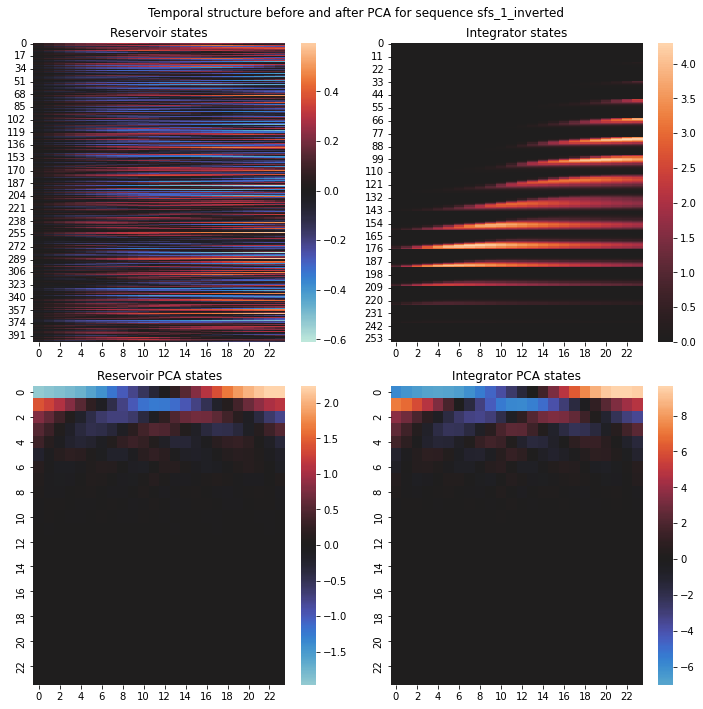

In [28]:
from sklearn.decomposition import PCA


# OBSERVATIONS: 
#     for reservoir states is a double map based on the training sequence and test sequence
#     for the linear integrator, there are no test sequences, only training sequences
# thus: to reduce one index in the reservoir states, we only consider a single train sequence per data set
train_set = {k : comparison_data[k][0] for k in paths} # for each test sequence, assign train set as first element in group
reservoir_states = { k : states[train_set[k]] [k] for k in paths }

# create map of algorithm to states
all_states = { 'Reservoir':reservoir_states, 'Integrator':linear_integrators }

# create function to process states to avoid repeating code
def process_data(data, function):
    return { algorithm : 
                { sequence : function(sequence_data) 
                  for sequence, sequence_data in algorithm_data.items() 
                } 
        for algorithm, algorithm_data in data.items()
    }

# PCA().fit(states['fss_0']['fss_0']).components_.shape



pca = process_data(all_states, lambda s : PCA().fit(s.copy()) )
variances = process_data(pca, lambda p : p.explained_variance_)

total_variances = process_data(variances, lambda v : v.sum())
percentual = process_data(variances, lambda v : v / v.sum())
accumulated = process_data(variances, lambda v : v.cumsum())
accumulated_percentual = process_data(percentual, lambda v : v.cumsum())

components = process_data(pca, lambda p : p.components_)
transformed = process_data(all_states, lambda s : PCA().fit_transform(s.copy()) )

def plot_pca_temporal_structure(reservoir_states, reservoir_pca_states, integrator_states, integrator_pca_states, sequence):
    %matplotlib inline
    fig= plt.figure(figsize=(10,10))
    fig.suptitle(f'Temporal structure before and after PCA for sequence {sequence}')
    
    plt.subplot(221)
    plt.title('Reservoir states')
    sns.heatmap(reservoir_states, center=0)
    
    plt.subplot(222)
    plt.title('Integrator states')
    sns.heatmap(integrator_states, center=0)
    
    plt.subplot(223)
    plt.title('Reservoir PCA states')
    sns.heatmap(reservoir_pca_states, center=0)
    
    plt.subplot(224)
    plt.title('Integrator PCA states')
    sns.heatmap(integrator_pca_states, center=0)
    fig.tight_layout()
    return fig

pca_tabs = create_empty_tabs(paths)
for k, p in pca_tabs.items():
    with pca_tabs[k]:
        var_dfs = {a : pd.DataFrame({ 'variance': variances[a][k], 
                                   'percentual':percentual[a][k], 
                                   'accumulated':accumulated[a][k], 
                                   'accumulated_percentual':accumulated_percentual[a][k]
                                    }) 
                   for a in all_states
        }
        
        display(Markdown('## Numerical results of PCA'))
        display(pd.concat(var_dfs, axis=1))
        display(components['Reservoir'][k].shape)
        
        percentual_df = pd.DataFrame({ a : percentual[a][k] for a in all_states})
        accumulated_df = pd.DataFrame({ a : accumulated_percentual[a][k] for a in all_states})
        
        display(Markdown('## Variance per PCA component'))
        percentual_df.plot_bokeh.line()
        
        display(Markdown('## Accumulated variance'))
        accumulated_df.plot_bokeh.line()
        
        display(Markdown('## Temporal structure before and after PCA'))
        
        display(plot_pca_temporal_structure(reservoir_states[k].T, transformed['Reservoir'][k].T ,linear_integrators[k].T, transformed['Integrator'][k].T, k))
        






